# Import packages

In [4]:
#from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#!pip install category_encoders
from category_encoders import OrdinalEncoder, OneHotEncoder
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from joblib import dump

# Load Data

In [2]:
# !pip install -q kaggle
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d'pschale/mlb-pitch-data-20152018'
# !mkdir data
# !unzip mlb-pitch-data-20152018.zip -d data

Saving kaggle.json to kaggle.json
 99% 366M/370M [00:03<00:00, 158MB/s]
100% 370M/370M [00:03<00:00, 122MB/s]
Archive:  mlb-pitch-data-20152018.zip
  inflating: data/2019_atbats.csv    
  inflating: data/2019_games.csv     
  inflating: data/2019_pitches.csv   
  inflating: data/atbats.csv         
  inflating: data/ejections.csv      
  inflating: data/games.csv          
  inflating: data/pitches.csv        
  inflating: data/player_names.csv   


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/n8mcdunna/rrherr-project2-example/master/data/2015_data.csv')

In [6]:
print(df.shape)
df.head()

(181685, 20)


,Unnamed: 0,batter_id,result,inning,pitcher_team_score,p_throws,pitcher_id,stand,top,attendance,away_team,elapsed_time,home_team,venue_name,weather,delay,year,wind_speed,wind_direction,temperature
0,0,572761,Out,1,0,L,452657,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
1,1,518792,On Base,1,0,L,452657,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
2,2,407812,On Base,1,0,L,452657,R,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
3,3,425509,Out,1,0,L,452657,R,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
4,4,571431,Out,1,0,L,452657,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44


In [62]:
# Reading in player names dataset. Other datasets will be read in and wrangled indiviudally

In [2]:
# pitches = pd.read_csv('data/pitches.csv')
# games = pd.read_csv('data/games.csv')
# atbats =  pd.read_csv('data/atbats.csv')
# player_names = pd.read_csv('data/player_names.csv')

In [3]:
#df = pd.merge(atbats, games, how= 'inner', on= 'g_id')
#df = pd.merge(pitches, df, how= 'inner', on= 'ab_id')

In [25]:
from datetime import datetime
date = datetime.strptime(df['date'][0], '%Y-%m-%d')
date.day

5

# Wrangling

In [4]:
def wrangle(df):
  df = df.copy()

  # Sorting at bats into 'on base' or 'out'
  df['event'].replace({
      'Strikeout': 'Out',
      'Groundout': 'Out',
      'Walk' : 'On Base',
      'Single' : 'On Base',
      'Flyout' : 'Out',
      'Lineout': 'Out',
      'Pop Out' : 'Out',
      'Double' : 'On Base',
      'Home Run' : 'On Base',
      'Forceout' : 'Out',
      'Grounded Into DP' : 'Out',
      'Field Error' : 'On Base', 
      'Hit By Pitch': 'On Base',
      'Triple' : 'On Base',
      'Double Play' : 'Out',
      'Intent Walk' : 'On Base',
      'Strikeout Double Play' : 'Out',
      'Fielders Choice' : 'Out',
      'Fielders Choice Out' : 'Out',
      'Bunt Pop Out' : 'Out',
      'Bunt Groundout' : 'Out',
      'Bunt Lineout' : 'Out',
      'Runner Out' : 'Out',
      'Triple Play' : 'Out',
      'Runner Double Play' : 'Out',
      'Strikeout - DP': 'Out',
      'Batter Interference': 'Out',
      'Catcher Interference' : 'On Base'

      # ,'Sac Fly': 'Out',
      # 'Sac Bunt': 'Out',
      # 'Sac Fly DP': 'Out',
      # 'Sacrifice Bunt DP': 'Out'
  }, inplace= True)

  # Filtering out sacrifice flys and bunts
  df = df[(df['event'] == 'On Base') | (df['event'] == 'Out')] 

  # Renaming abbreviated columns
  df = df.rename(mapper = {
      'ab_id': 'atbat_id',
      'event': 'result',
      'o': 'outs',
      'g_id': 'game_id', 
      'p_score': 'pitcher_team_score'
      }, axis= 1)
  
  # Making atbats readable
  df['atbat_id'] = df['atbat_id'].apply(int) 

  # Create feature for year, month, day of week
  def get_year(data):
    return str(data)[:4]
  df['year'] = df['game_id'].apply(get_year)

  #df = df.set_index('game_id')
  
  # Creating features and reducing cardinality of wind
  def wind_speed(data):
    return int(data.split(',')[0].strip()[:-4])
  def wind_direction(data):
    return data.split(',')[1].strip()
  df['wind_speed'] = df['wind'].apply(wind_speed)
  df['wind_direction'] = df['wind'].apply(wind_direction)
  df['wind_direction'].replace({'none': 'None'}, inplace= True)


  # Creating features for weather
  def temperature(data):
    return int(data.split(',')[0].strip()[:3])
  def weather(data):
    return data.split(',')[1].strip()
  df['temperature'] = df['weather'].apply(temperature)
  df['weather'] = df['weather'].apply(weather)

  # Duplicate, unnecessary, or potentailly data leakage columns
  df.drop(columns= ['outs', 'wind', 'away_final_score', 'home_final_score', 'atbat_id', 'game_id'], inplace= True)

  # Drop high cardinality columns
  high_card = [col for col in df.select_dtypes(include= 'object').columns if df[col].nunique() >= 100]
  df.drop(columns = high_card, inplace= True)
  #df.drop(columns= ['umpire_1B', 'umpire_2B', 'umpire_3B', 'umpire_HP'], inplace= True)


  return df

In [5]:
df = wrangle(df)
print(df.shape)
df.head()

(731567, 19)


,batter_id,result,inning,pitcher_team_score,p_throws,pitcher_id,stand,top,attendance,away_team,elapsed_time,home_team,venue_name,weather,delay,year,wind_speed,wind_direction,temperature
0,572761,Out,1,0,L,452657,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
1,518792,On Base,1,0,L,452657,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
2,407812,On Base,1,0,L,452657,R,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
3,425509,Out,1,0,L,452657,R,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44
4,571431,Out,1,0,L,452657,L,True,35055,sln,184,chn,Wrigley Field,clear,0,2015,7,In from CF,44


In [ ]:
df.select_dtypes(exclude= 'object').nunique()

In [ ]:
df['result'].value_counts()

In [ ]:
df.dtypes

## Wrangle pitches dataset

In [63]:
pitches = pd.read_csv('data/pitches.csv')

In [12]:
def wrangle_pitches(df):
  df = df.copy()

  # nulls = [col for col in df.columns if df[col].isnull().sum() == df.shape[0]]
  # print(nulls)
  # df.drop(columns= nulls, inplace= True)
  #df.drop(columns= ['code', 'o','event_num'], inplace= True) # code is duplicate of type, o is duplicate of outs, do not know what event_num is
  #df.drop(columns= ['spin_rate', 'spin_dir', 'type_confidence','zone'], inplace= True) # dropping placeholders. could use for advanced analysis
  #df.drop(columns= 'y0', inplace= True) # same value for all pitches: 50

  #advanced_stats = df.loc[:,:'pfx_z']
  #df.drop(columns= advanced_stats.columns, inplace= True)
  
  df = df.rename(mapper = {'ab_id': 'atbat_id', 
                           'g_id': 'game_id', 
                           'b_count':'balls', 
                           's_count':'strikes', 
                           'b_score':'batter_team_score', 
                           'p_score': 'pitcher_team_score'}, axis= 1)

  df['code'].replace({
      'B' : 'Ball', # ball
      '*B' : 'Ball', # ball in dirt
      'S' : 'Strike', # swinging strike
      'C' : 'Strike', # called strike
      'F' : 'Foul', # foul
      'T' : 'Foul', # foul tip
      'L' : 'Foul', # foul bunt
      'I' : 'Ball', # intentional ball
      'W' : 'Strike', # swinging strike blocked
      'M' : 'Strike', # missed bunt
      'P': 'Ball',
      'H': 'On Base', #'in play - no out', # hit by pitch
      'E': 'On Base', #'in play -  runs',
      'D': 'On Base', #'in play - no out',
      'X': 'Out', #'in play - out'
  }, inplace = True)

  # Selecting the walks when the ball count is at 3 and the pitch is a ball
  df.loc[(df['balls'] == 3) & (df['code'] == 'Ball'), 'code'] = 'On Base'

  # Selecting strikeouts when the strike count is at 2 and a strike is thrown
  df.loc[(df['strikes'] == 2) & (df['code'] == 'Strike'), 'code'] = 'Out'

  df = df[(df['code'] == 'Ball') | (df['code'] == 'Strike') | (df['code'] == 'Foul') | (df['code'] == 'On Base') | (df['code'] == 'Out')]

  df['pitch_type'].replace({
      'CH': 'Changeup',
      'CU': 'Curveball',
      'EP': 'Eephus',
      'FC': 'Cutter',
      'FF': 'Four seam fastball',
      'FO': 'Pitchout',
      'FS': 'Splitter',
      'FT': 'Two seam fastball',
      'IN': 'Intentional ball',
      'KC': 'Knuckle curve',
      'KN': 'Knuckleball',
      'PO': 'Pitchout',
      'SC': 'Screwball',
      'SI': 'Sinker',
      'SL': 'Slider',
      'UN': 'Unknown'
  }, inplace = True)

  # df['top'] = df['top'].astype(int) # changing 'top' of inning from boolean to binary

  df['atbbat_id'] = df['atbat_id'].apply(int) # making atbats readable

  # #df.dropna(inplace= True) 

  # Dropping outliers that have 4 balls in the count
  # four_balls = df[df['b_count'] == 4]
  # df.drop(four_balls.index, inplace= True)

  # Removing duplicate or data leakage
  df.drop(columns= ['type', 'event_num'], inplace= True)

  return df

In [13]:
pitches = wrangle_pitches(pitches)
print(pitches.shape)
pitches.head()

(2854774, 40)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,pitch_type,event_num,batter_team_score,atbat_id,balls,strikes,outs,pitch_num,on_1b,on_2b,on_3b,atbbat_id
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,Strike,Four seam fastball,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2015000001
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,Strike,Four seam fastball,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2015000001
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,Foul,Four seam fastball,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2015000001
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,Ball,Four seam fastball,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,2015000001
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,Ball,Curveball,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,2015000001


In [9]:
pitches['code'].value_counts()

Ball       970852
Strike     629856
Foul       528930
Out        478233
On Base    246903
Name: code, dtype: int64

In [ ]:
pitchers = df.groupby(['pitcher_id'])#['pitcher_id']
pitchers.head()

## Wrangle at_bats dataset

In [4]:
at_bats = pd.read_csv('data/atbats.csv')

In [5]:
def wrangle_at_bats(df):
  df = df.copy()

  # df['event'].replace({
  #     'Strikeout': 'Out',
  #     'Groundout': 'Out',
  #     'Walk' : 'On Base',
  #     'Single' : 'On Base',
  #     'Flyout' : 'Out',
  #     'Lineout': 'Out',
  #     'Pop Out' : 'Out',
  #     'Double' : 'On Base',
  #     'Home Run' : 'On Base',
  #     'Forceout' : 'Out',
  #     'Grounded Into DP' : 'Out',
  #     'Field Error' : 'On Base', # counted as on base since the batter did get on base
  #     'Hit By Pitch': 'On Base',
  #     'Triple' : 'On Base',
  #     'Double Play' : 'Out',
  #     'Intent Walk' : 'On Base',
  #     'Strikeout Double Play' : 'Out',
  #     'Fielders Choice' : 'Out',
  #     'Fielders Choice Out' : 'Out',
  #     'Bunt Pop Out' : 'Out',
  #     'Bunt Groundout' : 'Out',
  #     'Bunt Lineout' : 'Out',
  #     'Runner Out' : 'Out',
  #     'Triple Play' : 'Out',
  #     'Runner Double Play' : 'Out',
  #     'Strikeout - DP': 'Out',
  #     'Batter Interference': 'Out',
  #     'Catcher Interference' : 'On Base'

  #     # ,'Sac Fly': 'Out',
  #     # 'Sac Bunt': 'Out',
  #     # 'Sac Fly DP': 'Out',
  #     # 'Sacrifice Bunt DP': 'Out'
  # }, inplace= True)

  # df = df[(df['event'] == 'On Base') | (df['event'] == 'Out')] # filtering out sacrifice flys and bunts

  # df['event'].replace({
  #     'Out': 0,
  #     'On Base': 1
  # }, inplace = True)

  # df['top'] = df['top'].astype(int)
  
  df = df.rename(mapper = {'ab_id': 'atbat_id',
                           'event': 'result',
                           'o': 'outs',
                           'g_id': 'game_id', 
                           'p_score': 'pitcher_team_score'}, axis= 1)
  
  df['atbat_id'] = df['atbat_id'].apply(int) # making atbats readable

  # Removing data leakage
  df.drop(columns= ['outs', 'result'], inplace= True)
  return df



In [6]:
at_bats = wrangle_at_bats(at_bats)
print(at_bats.shape)
at_bats.head()

(740389, 10)


,atbat_id,batter_id,game_id,inning,pitcher_team_score,p_throws,pitcher_id,stand,top,atbbat_id
0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001
1,2015000002,518792,201500001,1,0,L,452657,L,True,2015000002
2,2015000003,407812,201500001,1,0,L,452657,R,True,2015000003
3,2015000004,425509,201500001,1,0,L,452657,R,True,2015000004
4,2015000005,571431,201500001,1,0,L,452657,L,True,2015000005


In [ ]:
at_bats['result'].value_counts(normalize = True)*100

In [ ]:
at_bats['outs'].value_counts()

In [ ]:
at_bats.groupby(by= 'outs')['result'].sum() / at_bats.groupby(by= 'outs')['result'].count()

In [ ]:
at_bats.nunique()

## Wrangle games dataset

In [7]:
games = pd.read_csv('data/games.csv')

In [8]:
def wrangle_games(df):
  df = df.copy()

  df = df.rename(mapper = {'g_id': 'game_id'}, axis= 1)

  # Create feature for year
  def get_year(data):
    return str(data)[:4]
  df['year'] = df['game_id'].apply(get_year)

  df = df.set_index('game_id')
  
  # Creating features and reducing cardinality of wind
  def wind_speed(data):
    return int(data.split(',')[0].strip()[:-4])
  def wind_direction(data):
    return data.split(',')[1].strip()
  df['wind_speed'] = df['wind'].apply(wind_speed)
  df['wind_direction'] = df['wind'].apply(wind_direction)
  df['wind_direction'].replace({'none': 'None'}, inplace= True)


  # Creating features for weather
  def temperature(data):
    return int(data.split(',')[0].strip()[:3])
  def weather(data):
    return data.split(',')[1].strip()
  df['temperature'] = df['weather'].apply(temperature)
  df['weather'] = df['weather'].apply(weather)

  # Duplicate or potentailly data leakage columns
  df.drop(columns= ['wind', 'away_final_score', 'home_final_score'], inplace= True)

  # Drop high cardinality columns
  high_card = [col for col in df.columns if df[col].nunique() >= 100]
  df.drop(columns = high_card, inplace= True)
  #df.drop(columns= ['umpire_1B', 'umpire_2B', 'umpire_3B', 'umpire_HP'], inplace= True)
  return df

In [9]:
games = wrangle_games(games)
print(games.shape)
games.head()

(9718, 8)


,away_team,home_team,venue_name,weather,year,wind_speed,wind_direction,temperature
game_id,,,,,,,,
201500001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
201500002,ana,sea,Safeco Field,cloudy,2015,1,Varies,54
201500003,atl,mia,Marlins Park,partly cloudy,2015,16,In from CF,80
201500004,bal,tba,Tropicana Field,dome,2015,0,None,72
201500005,bos,phi,Citizens Bank Park,partly cloudy,2015,11,Out to RF,71


In [10]:
games.nunique()

away_team         30
home_team         30
venue_name        39
weather           10
year               4
wind_speed        27
wind_direction    11
temperature       78
dtype: int64

In [ ]:
%matplotlib inline
games['attendance'].hist();

In [22]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9718 entries, 201500001 to 201802431
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   away_final_score  9718 non-null   int64 
 1   away_team         9718 non-null   object
 2   home_final_score  9718 non-null   int64 
 3   home_team         9718 non-null   object
 4   venue_name        9718 non-null   object
 5   weather           9718 non-null   object
 6   wind_speed        9718 non-null   int64 
 7   wind_direction    9718 non-null   object
 8   temperature       9718 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 759.2+ KB


In [ ]:
games['attendance'].hist()
plt.show();

## Merge the datasets

In [14]:
df = pd.merge(pitches, at_bats, how= 'inner', on= 'atbat_id')
df = pd.merge(df, games, how= 'inner', on= 'game_id')

In [15]:
print(df.shape)
df.head()

(2854774, 57)


,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,ay,az,sz_bot,sz_top,type_confidence,vx0,vy0,vz0,x,x0,y,y0,z0,pfx_x,pfx_z,nasty,zone,code,pitch_type,event_num,batter_team_score,atbat_id,balls,strikes,outs,pitch_num,on_1b,on_2b,on_3b,atbbat_id_x,batter_id,game_id,inning,pitcher_team_score,p_throws,pitcher_id,stand,top,atbbat_id_y,away_team,home_team,venue_name,weather,year,wind_speed,wind_direction,temperature
0,0.416,2.963,92.9,84.1,2305.052,159.235,-25.0,3.2,23.7,7.665,34.685,-11.960,1.72,3.56,2.0,-6.409,-136.065,-3.995,101.140000,2.280,158.780000,50.0,5.302,4.16,10.93,55.0,3.0,Strike,Four seam fastball,3,0.0,2.015000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
1,-0.191,2.347,92.8,84.1,2689.935,151.402,-40.7,3.4,23.7,12.043,34.225,-10.085,1.72,3.56,2.0,-8.411,-135.690,-5.980,124.280000,2.119,175.410000,50.0,5.307,6.57,12.00,31.0,5.0,Strike,Four seam fastball,4,0.0,2.015000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
2,-0.518,3.284,94.1,85.2,2647.972,145.125,-43.7,3.7,23.7,14.368,35.276,-11.560,1.72,3.56,2.0,-9.802,-137.668,-3.337,136.740000,2.127,150.110000,50.0,5.313,7.61,10.88,49.0,1.0,Foul,Four seam fastball,5,0.0,2.015000e+09,0.0,2.0,0.0,3.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
3,-0.641,1.221,91.0,84.0,1289.590,169.751,-1.3,5.0,23.8,2.104,28.354,-20.540,1.74,3.35,2.0,-8.071,-133.005,-6.567,109.685636,2.279,187.463482,50.0,5.210,1.17,6.45,41.0,13.0,Ball,Four seam fastball,6,0.0,2.015000e+09,0.0,2.0,0.0,4.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44
4,-1.821,2.083,75.4,69.6,1374.569,280.671,18.4,12.0,23.8,-10.280,21.774,-34.111,1.72,3.56,2.0,-6.309,-110.409,0.325,146.527525,2.179,177.242829,50.0,5.557,-8.43,-1.65,18.0,13.0,Ball,Curveball,7,0.0,2.015000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0,2015000001,572761,201500001,1,0,L,452657,L,True,2015000001,sln,chn,Wrigley Field,clear,2015,7,In from CF,44


In [25]:
id_cols = [col for col in df.columns if '_id' in col]
id_cols

['atbat_id', 'atbbat_id', 'batter_id', 'game_id', 'pitcher_id']

## Subsetting

In [33]:
df_2015 = df[df['year'] == '2015']

In [ ]:
df['away_team'].value_counts()

In [16]:
# Getting home and away games for oakland
oakland = df[(df['away_team'] == 'oak') | (df['home_team'] == 'oak')]

In [17]:
oakland_2015 = oakland[oakland['year'] == '2015']

In [18]:
oakland_2015.drop(columns= ['atbat_id', 'game_id', 'event_num'], inplace= True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
oakland_2015.drop(columns= ['atbbat_id_x', 'atbbat_id_y'], inplace= True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
print(oakland.shape)

(190638, 57)


In [20]:
print(oakland_2015.shape)

(47305, 54)


In [23]:
oakland_2015.nunique().head(50)

px                     4712
pz                     4972
start_speed             379
end_speed               353
spin_rate             46739
spin_dir              42402
break_angle            1133
break_length            182
break_y                   8
ax                    26266
ay                    16113
az                    24169
sz_bot                  102
sz_top                  137
type_confidence         582
vx0                   17766
vy0                   23046
vz0                   12722
x                      4831
x0                     6186
y                      5083
y0                        1
z0                     2839
pfx_x                  2924
pfx_z                  3038
nasty                    97
zone                     13
code                      5
pitch_type               15
batter_team_score        19
balls                     5
strikes                   3
outs                      3
pitch_num                14
on_1b                     2
on_2b               

# Modeling

In [34]:
df = df_2015

In [35]:
df.shape

(181685, 19)

In [ ]:
df.nunique()

## Baseline

In [36]:
print('Baseline:\n', round(df['result'].value_counts(normalize = True)*100, 3),'%')


Baseline:
 Out        67.279
On Base    32.721
Name: result, dtype: float64 %


In [25]:
print('Baseline:\n', round(df['code'].value_counts(normalize = True)*100, 3),'%')

Baseline:
 Ball       34.058
Strike     22.207
Foul       18.072
Out        16.954
On Base     8.709
Name: code, dtype: float64 %


## Train - test split

In [37]:
target = 'result'
y = df[target]
X = df.drop(columns= target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## First model 0.782
- using at_bats
- no features
- random forest : no tuning
- predicted probabilites


In [ ]:
y = at_bats['result']
X = at_bats.loc[:,'inning':]
X = X.drop(columns= 'pitcher_id')

# Splitting out test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs= -1,
        verbose= 1),
);
model.fit(X_train, y_train)

In [ ]:
score = cross_val_score(model, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')

In [ ]:
print('CV accuracy score:', score.mean())

In [ ]:
y_pred_proba = cross_val_predict(model, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:,1]

In [ ]:
y_plot = y_pred_proba.copy()
y_plot = sorted(y_plot)[:]

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
fig.set_figheight(10)
fig.set_figwidth(20)
plt.title('Prediction Probabilities')
plt.scatter(x= np.arange(len(y_plot)), y= y_plot, marker= '.')
plt.show();

## Second model 0.784
- using at_bats
- no features
- XGBoost

In [ ]:
y = at_bats['result']
X = at_bats.loc[:,'inning':]
X = X.drop(columns= 'pitcher_id')

# Splitting out test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
xgb_model = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)

In [ ]:
xgb_score = cross_val_score(xgb_model, X_train, y_train, scoring= 'accuracy', verbose= 1)

In [ ]:
print('XGB training accuracy:', xgb_score.mean())

## Third model 0.782
- low-card games and at_bats
- XGBoost
- no tuning

In [59]:
y = df['result']
X = df.drop(columns= 'result')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [ ]:
gb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs= -1)
)

In [ ]:
gb.fit(X_train, y_train)

In [ ]:
score = cross_val_score(gb, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

## Fourth model 0.584 accuracy
- classifying ball, strike, on base, out, or foul using all datasets
- removed data leakage columns: 
  - out, result, home_final_score, away_final_score

In [33]:
y = df['code']
X = df.drop(columns= 'code')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [27]:
gb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(n_jobs= -1)
)

In [28]:
score = cross_val_score(gb, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.5849276403389033


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [43]:
gb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['pitch_type', 'p_throws', 'stand',
                                      'away_team', 'home_team', 'venue_name',
                                      'weather', 'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'pitch_type',
                                          'data_type': dtype('O'),
                                          'mapping': Changeup               1
Four seam fastball     2
Two seam fastball      3
Sinker                 4
S...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                

## Fifth model 0.609 : 13.4 minutes to run cross-val scores
- using at_bats and games
- random forest
- more features and wrangling
- removed data leakage columns: outs, final score, 

In [8]:
rf_model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs = -1,
        verbose = 1
    ),
)
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtype('O'),
                                          'mapp...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth

In [40]:
score = cross_val_score(rf_model, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6090921327549343


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.4min finished


### Permutation importances

In [ ]:
perm_imp = permutation_importance(rf_model, 
                                  X_test, y_test)
                                  #n_jobs= -1) 
                                  #random_state= 42)

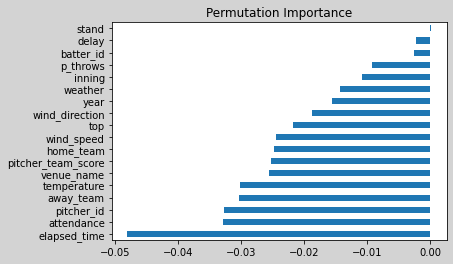

In [28]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.savefig('perm_imp_model_5.png')
plt.show();

## Sixth model 0.66965 : 34 seconds to run cross val score
- logistic regression
- same data as fifth model

In [20]:
lr = make_pipeline(
    OrdinalEncoder(),
    LogisticRegression(n_jobs = -1,
                       verbose = 1),
)
lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': R      1
L      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtype('O'),
                                          'mapp...
R to L         7
In from LF     8
Out to LF      9
Varies        10
Calm          11
NaN           -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('

In [21]:
score = cross_val_score(lr, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6696505613928767


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.0s finished


### Permutation importances

In [ ]:
# took over ten minutes to run
perm_imp = permutation_importance(rf_model, 
                                  X_test, y_test,
                                  #n_jobs= -1, 
                                  random_state= 42)

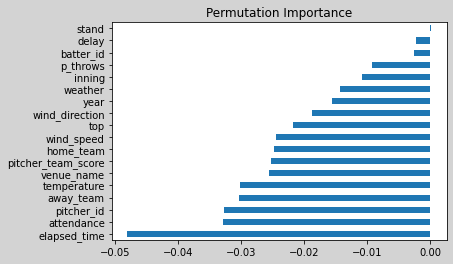

In [29]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.savefig('perm_imp_model_6.png')

plt.show();

In [32]:
from joblib import dump
lr_pickle = pickle.dumps(lr)
dump(lr, 'logreg_pickle.joblib')

['logreg_pickle.joblib']

## Seventh model 0.6718 : 42 seconds to run cross val scores
- baseline: 67.279
- using just 2015 data of fifth and sixth models
- xgboost

In [38]:
xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier()
)
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['p_throws', 'stand', 'away_team',
                                      'home_team', 'venue_name', 'weather',
                                      'year', 'wind_direction'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'p_throws',
                                          'data_type': dtype('O'),
                                          'mapping': L      1
R      2
NaN   -2
dtype: int64},
                                         {'col': 'stand',
                                          'data_type': dtype('O'),
                                          'mapp...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, 

In [39]:
score = cross_val_score(xgb, X_train, y_train, n_jobs = -1, verbose = 1, scoring= 'accuracy')
print('Accuracy score:', score.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Accuracy score: 0.6718289897837824


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.5s finished


### Permutation importances

In [40]:
# took 
perm_imp = permutation_importance(xgb, 
                                  X_test, y_test,
                                  #n_jobs= -1, 
                                  random_state= 42)

In [45]:
perm_imp

{'importances': array([[ 0.00000000e+00,  0.00000000e+00, -2.75201585e-05,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.75201585e-05, -2.75201585e-05,  0.000

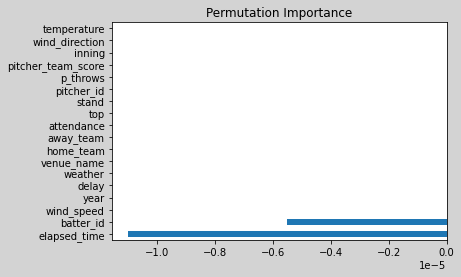

In [46]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.savefig('perm_imp_model_6.png')

plt.show();

In [48]:
from joblib import dump

dump(xgb, 'xgb_2015_pickle.joblib')

['xgb_2015_pickle.joblib']

In [ ]:
df.to_csv('2015_data.csv')

## PDP

### One feature

In [ ]:
!pip install pdpbox
!pip install shap

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [ ]:
feature = 'temperature'
isolated = pdp_isolate(
    model = gb,
    dataset = X_test,
    model_features = X_test.columns,
    feature= feature,
    num_grid_points = 70
)

pdp_plot(isolated, feature_name= feature);
plt.xlim(0, 100)

### Two features

In [ ]:
features = ['outs', 'inning']

interaction = pdp_interact(
    model= gb,
    features = features,
    dataset= X_test,
    model_features= X_test.columns
)

pdp_interact_plot(interaction, plot_type= 'grid', feature_names= features);

## Shapley

In [31]:
import shap

In [ ]:
transformer = make_pipeline(
    OrdinalEncoder()
)
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

data = [(X_train_transformed, y_train),
        (X_test_transformed, y_test)]

model = XGBClassifier(n_jobs= -1)
model.fit(X_train_transformed, y_train, eval_set = data)#, eval_metric= 'accuracy')

In [37]:
row = X_test.iloc[[1]]

In [ ]:
explainer = shap.TreeExplainer(model)
row_processed = transformer.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()

shap.force_plot(
    base_value= explainer.expected_value,
    shap_values= shap_values,
    features= row,
    link= 'logit',
    matplotlib = True,
    show= False
)
plt.savefig('shapley.png', bbox_inches = 'tight')

## ROC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_curve_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate' : tpr,
    'Thresholds': thresholds
})
roc

## Feature Importances

In [44]:
importances = gb.named_steps['xgbclassifier'].feature_importances_

In [45]:
feat_imp = pd.Series(importances, index= X_train.columns).sort_values()

In [ ]:
print(X_train.columns)

In [46]:
print(feat_imp)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
plt.title('Feature Importance for Random Forest Using Gini')
feat_imp.plot(kind= 'barh', xlabel = 'feature', ylabel= 'importance');

y0                    0.000000
p_throws              0.000000
pitcher_team_score    0.000000
venue_name            0.000000
top                   0.000000
year                  0.000000
weather               0.001143
break_y               0.001258
wind_direction        0.001487
away_team             0.002426
wind_speed            0.002501
ay                    0.002566
type_confidence       0.003086
home_team             0.003342
start_speed           0.003468
x0                    0.003687
pitcher_id            0.003745
temperature           0.003833
spin_rate             0.003904
z0                    0.004414
inning                0.004490
batter_id             0.004973
batter_team_score     0.005516
on_2b                 0.005961
on_1b                 0.006357
end_speed             0.006520
vx0                   0.007436
pitch_type            0.008306
sz_top                0.008350
ax                    0.008528
on_3b                 0.009331
vy0                   0.009546
pfx_z   

## Permutation importance

In [47]:
# perm_imp = permutation_importance(model, 
#                                   X_val, y_val, 
#                                   n_jobs= -1, 
#                                   random_state= 42)
perm_imp = permutation_importance(gb, 
                                  X_test, y_test, 
                                  n_jobs= -1, 
                                  random_state= 42)

In [48]:
perm_imp.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

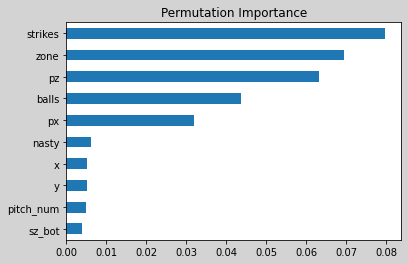

In [58]:
%matplotlib inline
data = {
    'importances_mean' : perm_imp['importances_mean'],
    'importances_std' : perm_imp['importances_std']
}

perm_imp_df = pd.DataFrame(data, index= X_test.columns)
perm_imp_df.sort_values(by = 'importances_mean', ascending= True, inplace= True)

fig, ax = plt.subplots()
fig.set_facecolor('lightgrey')
perm_imp_df['importances_mean'].tail(10).plot(kind= 'barh')
#plt.xlabel('change in model accuracy')
plt.title('Permutation Importance')
plt.show();